In [1]:
%matplotlib inline

# Algs

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# returns e = (r,v)  from x such that weight of (r,v) is minimum
def min_cost_edge(tr_cl, r, x):
    min = 9999999
    res_v = None
    adjs = [a[1] for a in tr_cl.out_edges(r)]
    adjs = set(adjs) - {r}
    intersect = adjs & set(x)
    for v in intersect:
        val = tr_cl[r][v]['weight']
        if val < min:
            res_v = v
            min = val
    return r, res_v, min


def sort_list_intersect(a=[], b=[]):
    res = []
    i = j = 0
    while i < len(a) and j < len(b):
        if a[i] > b[j]:
            j += 1
        elif b[j] > a[i]:
            i += 1
        else:
            res.append(a[i])
            i += 1
            j += 1
    return res


# return -1 if not exist
def bin_search(a, x, lo=0, hi=None):
    if hi is None:
        hi = len(a)
    while lo < hi:
        mid = (lo + hi) // 2
        midval = a[mid]
        if midval < x:
            lo = mid + 1
        elif midval > x:
            hi = mid
        else:
            return mid
    return -1


def get_density(tree=nx.DiGraph(), x=[]):
    tot_weight = float(tree.size(weight='weight'))
    nodes = nx.nodes(tree)
    intersect = set(nodes) & set(x)
    if len(intersect) == 0:
        return float('inf')
    else:
        return tot_weight / len(intersect)


def get_density_with_edge(tree=nx.DiGraph(), x=[], edge=tuple()):
    tot_weight = float(tree.size(weight='weight'))
    tot_weight += edge[2]
    nodes = set(nx.nodes(tree)) | {edge[0], edge[1]}  # union of vertices from tree and from edge
    intersect = nodes & set(x)
    if len(intersect) == 0:
        return float('inf')
    else:
        return tot_weight / len(intersect)


def merge_trees(tree1=nx.DiGraph(), tree2=nx.DiGraph()):
    # print(tree1.edges(data=True))
    # print(tree2.edges(data=True))
    edges2 = [(v, u, tree2[v][u]['weight']) for v, u in nx.edges(tree2)]
    tree1.add_weighted_edges_from(edges2)
    # print(tree1.edges(data=True))
    return tree1



# MST algs

In [ ]:
import time
import networkx as nx
# from random import choices
from random import random
from numpy.random import choice
import numpy as np

start_time = -1
time_out = 10000


def trans_clos(DG):
    adjs = nx.all_pairs_dijkstra_path_length(DG)
    # adjs = nx.floyd_warshall_numpy(DG)
    edges = []
    tr_cl = nx.DiGraph()
    for source, adj in zip(adjs.keys(), adjs.values()):
        for dest, weight in zip(adj.keys(), adj.values()):
            t = (source, dest, weight)
            edges.append(t)
    tr_cl.add_weighted_edges_from(edges)
    return tr_cl


def trans_clos_dense(DG):
    adjs = nx.floyd_warshall_numpy(DG)
    edges = []
    nodes = nx.nodes(DG)
    i = 0
    for node1 in nodes:
        j = 0
        for node2 in nodes:
            t = (node1, node2, float(adjs[i, j]))
            edges.append(t)
            j += 1
        i += 1
    tr_cl = nx.DiGraph()
    tr_cl.add_weighted_edges_from(edges)
    return tr_cl


def set_start_time(t):
    global start_time
    start_time = t


def get_elapsed_time():
    return time.time() - start_time


def print_graph(g):
    # pos = nx.get_node_attributes(g, 'pos')
    from networkx.drawing.nx_agraph import graphviz_layout
    nx.draw(g, node_size=100, with_labels=True)
    # nx.draw_networkx_edges(G=g, pos = nx.spring_layout(g))


def print_tree(g, root):
    tree = nx.bfs_tree(g, root)
    # pos=nx.graphviz_layout(g,prog='twopi',args='')
    nx.draw(tree, with_labels=True, pos=nx.shell_layout(g))
    # plt.show()


def alg3(tr_cl, i=0, k=0, r=0, x=[]):
    t = nx.DiGraph()
    prev = -1
    if i == 1:
        while k > 0:
            e = min_cost_edge(tr_cl, r, x)
            if e[1] is None:
                k -= 1
                continue

            t.add_edge(e[0], e[1], weight=e[2])
            k -= 1
            # pos = bin_search(x, e[1])
            pos = x.index(e[1])
            del x[pos]
    else:
        while k > 0:
            # x.sort()
            t_best = nx.DiGraph()
            den_best = float('inf')
            vertices = nx.nodes(tr_cl)
            # l1 = len(vertices)
            # l2 = len(vertices)
            # print(l1,l2)
            # exit()
            for v in vertices:
                if get_elapsed_time() > time_out:
                    raise Exception('Alg took too long to calculate')
                for kp in range(1, k + 1):
                    tp = alg3(tr_cl, i=i - 1, k=kp, r=v, x=x.copy())
                    tp.add_edge(r, v, weight=tr_cl[r][v]['weight'])
                    tp_den = get_density(tp, x)
                    if den_best > tp_den:
                        den_best = tp_den
                        t_best = tp
            t = merge_trees(t, t_best)
            k -= len(set(x) & set(nx.nodes(t_best)))
            x = list(set(x) - set(nx.nodes(t_best)))
            if i == 3:
                print("k3 =", k)
            if i == 4:
                print("k4 =", k)
            if prev == k:
                k -= 1
                break
            prev = k
    return t

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def alg4(tr_cl, i=0, k=0, r=0, x=[]):
    t = nx.DiGraph()
    prev = -1
    if i == 1:
        while k > 0:
            e = min_cost_edge(tr_cl, r, x)
            if e[1] is not None:
                t.add_weighted_edges_from([e])
            k -= 1
            if e[1] is not None:
                # pos = bin_search(x, e[1])
                pos = x.index(e[1])
                del x[pos]
    else:
        while k > 0:
            t_best = nx.DiGraph()
            den_best = float('inf')
            vertices = nx.nodes(tr_cl)
            count = 0
            densities = []
            trees = []
            # while count == 0:
            for v in vertices:
                # if random() > 0.75:
                #     continue
                count += 1
                edge = (r, v, tr_cl[r][v]['weight'])
                tp = alg5(tr_cl, i=i - 1, k=k, r=v, x=x.copy(), edge=edge)
                tp.add_edge(edge[0], edge[1], weight=edge[2])
                tp_den = get_density(tp, x)
                densities.append(1/tp_den)
                trees.append(tp)
                # if den_best > tp_den:
                #     den_best = tp_den
                #     t_best = tp
            t_best = choice(trees, p=softmax(np.array(densities)*30))

            if get_elapsed_time() > time_out:
                raise Exception('Alg took too long to calculate')
#             print('den_best = ', den_best)
            t = merge_trees(t, t_best)
            k -= len(set(x) & set(nx.nodes(t_best)))
            x = list(set(x) - set(nx.nodes(t_best)))
            print("k=", k)
            if prev == k:
                print('bad')
                k -= 1
            prev = k
    return t


def check_sorted(x):
    prev = x[0]
    for el in x:
        if el < prev:
            return False
        prev = el
    return True


def alg5(tr_cl, i=0, k=0, r=0, x=[], edge=None):
    t = nx.DiGraph()
    tc = nx.DiGraph()
    te_den = float('inf')
    oldx = x.copy()
    prev = -1
    if i == 1:
        while k > 0:
            e = min_cost_edge(tr_cl, r, x)
            if e[1] is not None:
                tc.add_edge(e[0], e[1], weight=e[2])
            k -= 1
            # if random() > 0.75:
            #     continue
            tce_den = get_density_with_edge(tc, oldx, edge)
            if e[1] is not None:
                pos = x.index(e[1])
                # pos = bin_search(x,e[1])
                del x[pos]
            if te_den > tce_den:
                te_den = tce_den
                t = tc.copy()
    else:
        while k > 0:
            t_best = nx.DiGraph()
            den_best = float('inf')
            vertices = nx.nodes(tr_cl)
            for v in vertices:
                edge = (r, v, tr_cl[r][v]['weight'])
                tp = alg5(tr_cl, i=i - 1, k=k, r=v, x=x.copy(), edge=edge)
                tp.add_edge(edge[0], edge[1], weight=edge[2])
                tp_den = get_density(tp, x)
                if den_best > tp_den:
                    den_best = tp_den
                    t_best = tp
            tc = merge_trees(tc, t_best)
            k -= len(set(x) & set(nx.nodes(t_best)))
            if get_density_with_edge(t, x, edge) > get_density_with_edge(tc, x, edge):
                t = tc
            if k == prev:
                k -= 1
                break
            x = list(set(x) - set(nx.nodes(t_best)))
            prev = k
    return t


def alg6(tr_cl, i=0, k=0, r=0, x=[]):
    t = nx.DiGraph()
    prev = -1
    if i == 1:
        while k > 0:
            e = min_cost_edge(tr_cl, r, x)
            if e[1] is not None:
                t.add_weighted_edges_from([e])
            k -= 1
            if e[1] is not None:
                pos = x.index(e[1])
                del x[pos]
    else:
        first = True
        vertices = nx.nodes(tr_cl)
        x = list(set(x) & set(vertices))
        m = dict()
        while k > 0:
            t_best = nx.DiGraph()
            den_best = float('inf')
            if first:
                for v in vertices:
                    edge = (r, v, tr_cl[r][v]['weight'])
                    tp = alg7(tr_cl, i=i - 1, k=k, r=v, x=x.copy(), edge=edge)
                    tp.add_edge(edge[0], edge[1], weight=edge[2])
                    tp_den = get_density(tp, x)
                    m[v] = tp_den
                    if den_best > tp_den:
                        den_best = tp_den
                        t_best = tp
                vertices.sort(key=m.get)
                first = False
            else:
                for v in vertices:
                    if m[v] < den_best:
                        edge = (r, v, tr_cl[r][v]['weight'])
                        tp = alg7(tr_cl, i=i - 1, k=k, r=v, x=x.copy(), edge=edge)
                        tp.add_edge(edge[0], edge[1], weight=edge[2])
                        tp_den = get_density(tp, x)
                        m[v] = tp_den
                        if den_best > tp_den:
                            den_best = tp_den
                            t_best = tp
                    else:
                        vertices.sort(key=m.get)
                        break
            if get_elapsed_time() > time_out:
                raise Exception('Alg took too long to calculate')
            t = merge_trees(t, t_best)
            k -= len(set(x) & set(nx.nodes(t_best)))
            x = list(set(x) - set(nx.nodes(t_best)))
            print("k=", k)
            if prev == k:
                print('bad')
                k -= 1
            prev = k
    return t

def rand_alg6(tr_cl, i=0, k=0, r=0, x=[]):
    t = nx.DiGraph()
    prev = -1
    if i == 1:
        while k > 0:
            e = min_cost_edge(tr_cl, r, x)
            if e[1] is not None:
                t.add_weighted_edges_from([e])
            k -= 1
            if e[1] is not None:
                pos = x.index(e[1])
                del x[pos]
    else:
        first = True
        vertices = nx.nodes(tr_cl)
        x = list(set(x) & set(vertices))
        m = dict()
        while k > 0:
            t_best = nx.DiGraph()
            den_best = float('inf')
            densities = []
            trees = []
            if first:
                for v in vertices:
                    edge = (r, v, tr_cl[r][v]['weight'])
                    tp = alg7(tr_cl, i=i - 1, k=k, r=v, x=x.copy(), edge=edge)
                    tp.add_edge(edge[0], edge[1], weight=edge[2])
                    tp_den = get_density(tp, x)
                    m[v] = tp_den
                    densities.append(1/tp_den)
                    trees.append(tp)
#                     if den_best > tp_den:
#                         den_best = tp_den
#                         t_best = tp
                t_best = choice(trees, p=softmax(np.array(densities)*30))
                vertices.sort(key=m.get)
                first = False
            else:
                for v in vertices:
                    if m[v] < den_best:
                        edge = (r, v, tr_cl[r][v]['weight'])
                        tp = alg7(tr_cl, i=i - 1, k=k, r=v, x=x.copy(), edge=edge)
                        tp.add_edge(edge[0], edge[1], weight=edge[2])
                        tp_den = get_density(tp, x)
                        m[v] = tp_den
                        densities.append(1/tp_den)
                        trees.append({tp})
                        if den_best > tp_den:
                            den_best = tp_den
                            t_best = tp
                    else:
                        t_best = choice(trees, p=softmax(np.array(densities)*30)).pop()
                        vertices.sort(key=m.get)
                        break
            if get_elapsed_time() > time_out:
                raise Exception('Alg took too long to calculate')
            t = merge_trees(t, t_best)
            k -= len(set(x) & set(nx.nodes(t_best)))
            x = list(set(x) - set(nx.nodes(t_best)))
#             print("k=", k)
            if prev == k:
                print('bad')
                k -= 1
            prev = k
    return t

def alg7(tr_cl, i=0, k=0, r=0, x=[], edge=None):
    t = nx.DiGraph()
    tc = nx.DiGraph()
    te_den = float('inf')
    oldx = x.copy()
    prev = -1
    if i == 1:
        while k > 0:
            e = min_cost_edge(tr_cl, r, x)
            if e[1] is not None:
                tc.add_edge(e[0], e[1], weight=e[2])
            k -= 1
            tce_den = get_density_with_edge(tc, oldx, edge)
            if e[1] is not None:
                pos = x.index(e[1])
                # pos = bin_search(x,e[1])
                del x[pos]
            if te_den > tce_den:
                te_den = tce_den
                t = tc.copy()
    else:
        first = True
        vertices = nx.nodes(tr_cl)
        x = list(set(x) & set(vertices))
        m = dict()
        while k > 0:
            t_best = nx.DiGraph()
            den_best = float('inf')
            if first:
                for v in vertices:
                    edge = (r, v, tr_cl[r][v]['weight'])
                    tp = alg7(tr_cl, i=i - 1, k=k, r=v, x=x.copy(), edge=edge)
                    tp.add_edge(edge[0], edge[1], weight=edge[2])
                    tp_den = get_density(tp, x)
                    m[v] = tp_den
                    if den_best > tp_den:
                        den_best = tp_den
                        t_best = tp
                vertices.sort(key=m.get)
                first = False
            else:
                for v in vertices:
                    if m[v] < den_best:
                        edge = (r, v, tr_cl[r][v]['weight'])
                        tp = alg7(tr_cl, i=i - 1, k=k, r=v, x=x.copy(), edge=edge)
                        tp.add_edge(edge[0], edge[1], weight=edge[2])
                        tp_den = get_density(tp, x)
                        m[v] = tp_den
                        if den_best > tp_den:
                            den_best = tp_den
                            t_best = tp
                    else:
                        vertices.sort(key=m.get)
                        break

            tc = merge_trees(tc, t_best)
            k -= len(set(x) & set(nx.nodes(t_best)))
            if get_density_with_edge(t, x, edge) > get_density_with_edge(tc, x, edge):
                t = tc
            if k == prev:
                k -= 1
                break
            x = list(set(x) - set(nx.nodes(t_best)))
            prev = k
    return t


In [107]:
import time
import networkx as nx
import sys


def get_graph(filename, with_root=False):
    DG = nx.DiGraph()
    f = open(filename, 'r')
    line = None
    edges = []
    coordinates = []
    terms = []
    if with_root:
        root = None
    while line != 'EOF':
        line = f.readline().strip()
        toks = line.split(' ')
        if toks[0] == 'E':
            t = tuple(int(x) for x in toks[1:])
            edges.append(t)
        if toks[0] == 'T':
            terms.append(int(toks[1]))
        if toks[0] == 'Root':
            if with_root:
                root = int(toks[1])
        if toks[0] == 'DD':
            t = tuple(int(x) for x in toks[1:])
            coordinates.append(t)
    for coord in coordinates:
        DG.add_node(coord[0], pos=(coord[1], coord[2]))
    terms.sort()
    DG.add_weighted_edges_from(edges)
    # print_graph(DG)
    # nx.draw(DG, node_size=50)
    # plt.show()
    # f.close()
    if with_root:
        return DG, terms, root
    else:
        print_graph(DG)
        max_len = 0
        max_node = None
        for node in nx.nodes(DG):
            # print(node, tr_cl.out_edges(node))
            descs = nx.descendants(DG, node)
            # desc_numb = len(descs)
            if len(set(terms) & set(descs)) == len(descs):
                # max_len = desc_numb
                max_node = node
        if max_len == len(nx.nodes(DG)):
            return DG, terms, max_node
        else:
            reachable = set(nx.descendants(DG, max_node)) | {max_node}
            unreachable = set(nx.nodes(DG)) - reachable
            for node in unreachable:
                DG.remove_node(node)
        terms = list(set(terms) & reachable)
        print('terms =', len(terms))
        return DG, terms, max_node


def cmd_test(filename, alg, i):
    DG, terms, root = get_graph(filename, with_root=True)

    v = nx.number_of_nodes(DG)
    e = nx.number_of_edges(DG)

    print('root is', root)
    print("Number of vertices: ", v)
    print("Number of reachable vertices: ", len(nx.descendants(DG, root)) + 1)
    print("Number of terms: ", len(terms))
    print("Number of edges: ", e)
    print('')
    print('apsp started')
    start_time = time.time()
    tr_cl = trans_clos_dense(DG)
    # print_graph(tr_cl)
    elapsed_time = time.time() - start_time
    print('apsp finished in', elapsed_time)

    if alg == 'alg3':
        print('Alg3 with i = ', i, 'started')
        start_time = time.time()
        set_start_time(start_time)
        terms.sort()
        tree = alg3(tr_cl, i=i, k=len(terms), r=root, x=terms)
        elapsed_time = time.time() - start_time
        print('Elapsed time = ', elapsed_time)
        tot_weight = tree.size(weight='weight')
        print('Weight of MSTw = ', tot_weight)
    if alg == 'alg4':
        print('Alg4 with i = ', i, 'started')
        start_time = time.time()
        set_start_time(start_time)
        terms.sort()
        tree = alg4(tr_cl, i=i, k=len(terms), r=root, x=terms)
        elapsed_time = time.time() - start_time
        print('Elapsed time = ', elapsed_time)
        tot_weight = tree.size(weight='weight')
        print('Weight of MSTw = ', tot_weight)
        print(set(terms) <= set(tree.nodes()))
    if alg == 'alg6':
        print('Alg6 with i = ', i, 'started')
        start_time = time.time()
        set_start_time(start_time)
        terms.sort()
        tree = alg6(tr_cl, i=i, k=len(terms), r=root, x=terms)
        elapsed_time = time.time() - start_time
        print('Elapsed time = ', elapsed_time)
        tot_weight = tree.size(weight='weight')
        print('Weight of MSTw = ', tot_weight)
    if alg == 'rand_alg6':
        print('Rand Alg6 with i = ', i, 'started')
        start_time = time.time()
        set_start_time(start_time)
        terms.sort()
        tree = rand_alg6(tr_cl, i=i, k=len(terms), r=root, x=terms)
        elapsed_time = time.time() - start_time
        print('Elapsed time = ', elapsed_time)
        tot_weight = tree.size(weight='weight')
        print('Weight of MSTw = ', tot_weight)
        print(set(terms) <= set(tree.nodes()))
    return tree, tot_weight

args = sys.argv
# filename = 'statics/131_186.txt'
# filename = 'statics/265_360.txt' # 95
# filename = 'statics/1465_2184.txt' # 440.0
filename = 'statics/2521_3738.txt' # 830.0
alg = 'rand_alg6'
i = 2
w_list = []
for j in range(15):
    t, w = cmd_test(filename, alg, i)
    w_list.append(w)
    print(j)
#     print_graph(t)
# plt.show()

root is 1
Number of vertices:  2521
Number of reachable vertices:  2521
Number of terms:  652
Number of edges:  2941

apsp started
apsp finished in 77.91592764854431
Rand Alg6 with i =  2 started
Elapsed time =  1809.4705414772034
Weight of MSTw =  836.0
True
0
root is 1
Number of vertices:  2521
Number of reachable vertices:  2521
Number of terms:  652
Number of edges:  2941

apsp started
apsp finished in 77.25706076622009
Rand Alg6 with i =  2 started
Elapsed time =  1822.4034230709076
Weight of MSTw =  850.0
True
1
root is 1
Number of vertices:  2521
Number of reachable vertices:  2521
Number of terms:  652
Number of edges:  2941

apsp started
apsp finished in 77.03815412521362
Rand Alg6 with i =  2 started
Elapsed time =  1813.449604511261
Weight of MSTw =  837.0
True
2
root is 1
Number of vertices:  2521
Number of reachable vertices:  2521
Number of terms:  652
Number of edges:  2941

apsp started
apsp finished in 77.22695446014404
Rand Alg6 with i =  2 started
Elapsed time =  182

KeyboardInterrupt: 

In [108]:
t, w

(<networkx.classes.digraph.DiGraph at 0x7ff6dc487080>, 845.0)

mean =  844.153846154
var =  22.2840236686


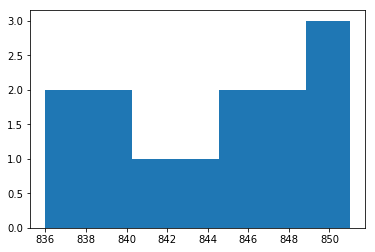

In [111]:
print("mean = ", np.mean(w_list))
print("var = ", np.var(w_list))
plt.hist(w_list, bins=7)
plt.show()

In [32]:
len(w_list)

20

In [3]:
import random
random.choices

<bound method Random.choices of <random.Random object at 0x1b4dc58>>